In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)
sns.set_palette("colorblind")          # colour‑blind‑friendly palette
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.right"]  = False
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.frameon"]     = False

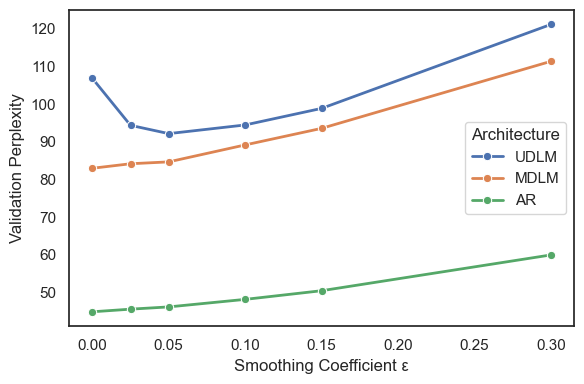

In [18]:
# label smoothing
data = {
    "Smoothing": [0.0, 0.025, 0.05, 0.1, 0.15, 0.3],
    "AR":        [44.9, 45.6, 46.2, 48.2, 50.5, 60.0],
    "MDLM":      [83.0, 84.2, 84.7, 89.2, 93.6, 111.4],
    "UDLM":      [106.9, 94.4, 92.2, 94.5, 98.9, 121.2],
}
df_wide = pd.DataFrame(data)
df_long = df_wide.melt(id_vars="Smoothing",
                       value_vars=["AR", "MDLM", "UDLM"],
                       var_name="Model",
                       value_name="Perplexity")
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=df_long[::-1],
             x="Smoothing",
             y="Perplexity",
             hue="Model",
             marker="o",
             linewidth=2,
             ax=ax)

# ax.set_title("Label Smoothing Ablation")
ax.set_xlabel("Smoothing Coefficient ε")
ax.set_ylabel("Validation Perplexity")
# ax.invert_yaxis()          # optional: low perplexity at top
ax.legend(title="Architecture", loc="right", frameon=True)


plt.tight_layout()
plt.savefig("label_smoothing.png", dpi=300, bbox_inches="tight")
plt.show()

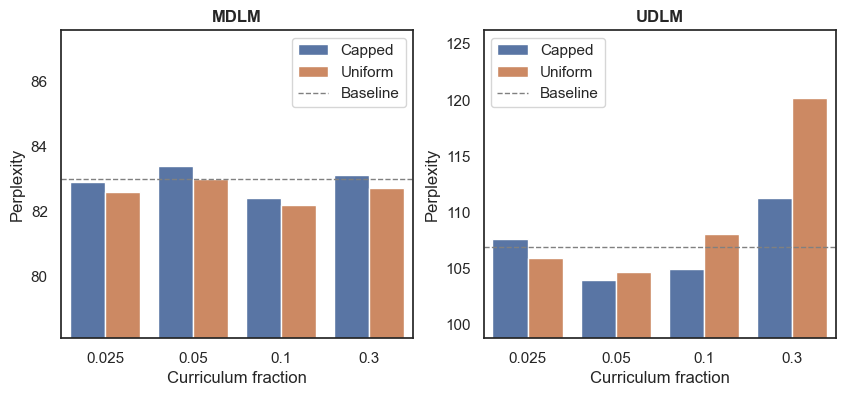

In [19]:
# noise schedule
df = pd.DataFrame(
    [
        # MDLM – capped
        (0.025, "Capped",   "MDLM", 82.9),
        (0.050, "Capped",   "MDLM", 83.4),
        (0.100, "Capped",   "MDLM", 82.4),
        (0.300, "Capped",   "MDLM", 83.1),
        # MDLM – uniform‑scaled
        (0.025, "Uniform",  "MDLM", 82.6),
        (0.050, "Uniform",  "MDLM", 83.0),
        (0.100, "Uniform",  "MDLM", 82.2),
        (0.300, "Uniform",  "MDLM", 82.7),

        # UDLM – capped
        (0.025, "Capped",   "UDLM", 107.6),
        (0.050, "Capped",   "UDLM", 104.0),
        (0.100, "Capped",   "UDLM", 105.0),
        (0.300, "Capped",   "UDLM", 111.3),
        # UDLM – uniform‑scaled
        (0.025, "Uniform",  "UDLM", 105.9),
        (0.050, "Uniform",  "UDLM", 104.7),
        (0.100, "Uniform",  "UDLM", 108.1),
        (0.300, "Uniform",  "UDLM", 120.2),
    ],
    columns=["Curriculum", "Technique", "Model", "Perplexity"],
)
# palette = {"Capped": "#1f77b4", "Uniform": "#ff7f0e"}
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

for ax, model, baseline in zip(
    axes,
    ["MDLM", "UDLM"],
    [83.0, 106.9],          # baseline perplexities
):
    sns.barplot(
        data=df[df["Model"] == model],
        x="Curriculum",
        y="Perplexity",
        hue="Technique",
        # palette=palette,
        ax=ax,
    )

    ax.axhline(
        baseline,
        ls="--",
        lw=1,
        color="gray",
        label=f"Baseline",
    )

    ax.set_title(f"{model}")
    ax.set_ylim(df[df["Model"] == model]["Perplexity"].min() * 0.95, df[df["Model"] == model]["Perplexity"].max() * 1.05)
    ax.set_xlabel("Curriculum fraction")
    ax.set_ylabel("Perplexity")
    ax.legend(frameon=True)

plt.savefig("noise_schedule.png", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/_s/zcd4d6nj55j53lv8b01ng45w0000gn/T/ipykernel_39990/1620152759.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/_s/zcd4d6nj55j53lv8b01ng45w0000gn/T/ipykernel_39990/1620152759.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/_s/zcd4d6nj55j53lv8b01ng45w0000gn/T/ipykernel_39990/1620152759.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


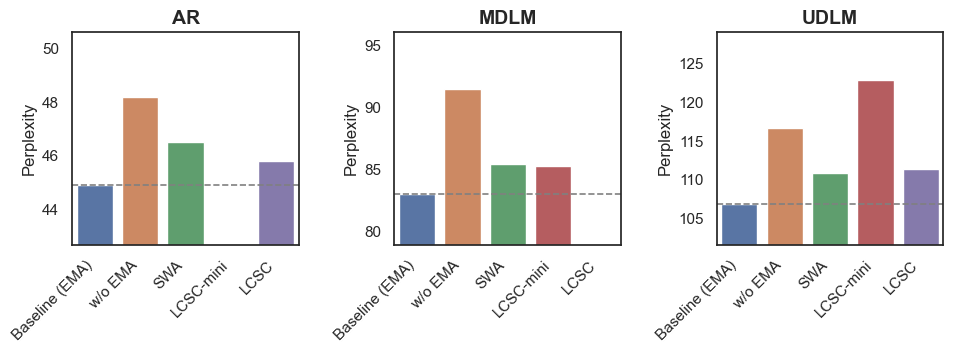

In [20]:
# weights averaging
records = [
    ("Baseline (EMA)",  "AR",   44.9),
    ("Baseline (EMA)",  "MDLM", 83.0),
    ("Baseline (EMA)",  "UDLM", 106.9),
    ("w/o EMA",         "AR",   48.2),
    ("w/o EMA",         "MDLM", 91.5),
    ("w/o EMA",         "UDLM", 116.7),
    ("SWA",             "AR",   46.5),
    ("SWA",             "MDLM", 85.4),
    ("SWA",             "UDLM", 110.9),
    ("LCSC-mini",       "AR", None),
    ("LCSC-mini",       "MDLM", 85.2),
    ("LCSC-mini",       "UDLM", 122.9),
    ("LCSC",            "MDLM",  None),
    ("LCSC",            "AR",   45.8),
    ("LCSC",            "UDLM", 111.3)
]

df = pd.DataFrame(records, columns=["Technique", "Model", "Perplexity"])

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=False)
model_order = ["AR", "MDLM", "UDLM"]
baseline_val  = {"AR": 44.9, "MDLM": 83.0, "UDLM": 106.9}

for ax, model in zip(axes, model_order):
    sns.barplot(
        data=df[df["Model"] == model],
        x="Technique",
        y="Perplexity",
        # palette="pastel",
        hue="Technique",
        ax=ax
    )
    ax.axhline(
        baseline_val[model],
        ls="--", lw=1.2, color="grey", zorder=1
    )
    ax.set_title(model, fontsize=14, weight="bold")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylim(df[df["Model"] == model]["Perplexity"].min() * 0.95, df[df["Model"] == model]["Perplexity"].max() * 1.05)
    ax.set_ylabel("Perplexity")

# fig.suptitle("Parameter‑Averaging Techniques Across Models", fontsize=16, weight="bold")
fig.tight_layout(pad=2)
plt.savefig("weights_averaging.png", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/_s/zcd4d6nj55j53lv8b01ng45w0000gn/T/ipykernel_39990/3993224043.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/_s/zcd4d6nj55j53lv8b01ng45w0000gn/T/ipykernel_39990/3993224043.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/_s/zcd4d6nj55j53lv8b01ng45w0000gn/T/ipykernel_39990/3993224043.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


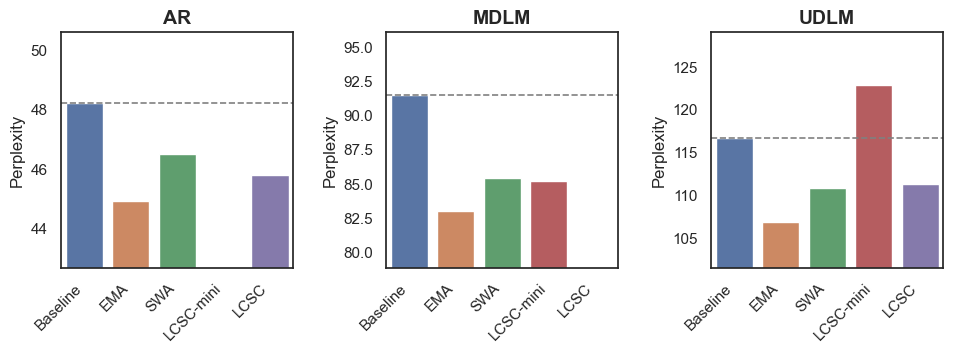

In [21]:
# weights averaging
records = [
    ("Baseline",         "AR",   48.2),
    ("Baseline",         "MDLM", 91.5),
    ("Baseline",         "UDLM", 116.7),
    ("EMA",             "AR",   44.9),
    ("EMA",         "MDLM", 83.0),
    ("EMA",             "UDLM", 106.9),
    ("SWA",             "AR",   46.5),
    ("SWA",             "MDLM", 85.4),
    ("SWA",             "UDLM", 110.9),
    ("LCSC-mini",       "AR", None),
    ("LCSC-mini",       "MDLM", 85.2),
    ("LCSC-mini",       "UDLM", 122.9),
    ("LCSC",            "MDLM",  None),
    ("LCSC",            "AR",   45.8),
    ("LCSC",            "UDLM", 111.3)
]

df = pd.DataFrame(records, columns=["Technique", "Model", "Perplexity"])

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=False)
model_order = ["AR", "MDLM", "UDLM"]
baseline_val  = {"AR": 48.2, "MDLM": 91.5, "UDLM": 116.7}

for ax, model in zip(axes, model_order):
    sns.barplot(
        data=df[df["Model"] == model],
        x="Technique",
        y="Perplexity",
        # palette="pastel",
        hue="Technique",
        ax=ax
    )
    ax.axhline(
        baseline_val[model],
        ls="--", lw=1.2, color="grey", zorder=1
    )
    ax.set_title(model, fontsize=14, weight="bold")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylim(df[df["Model"] == model]["Perplexity"].min() * 0.95, df[df["Model"] == model]["Perplexity"].max() * 1.05)
    ax.set_ylabel("Perplexity")

# fig.suptitle("Parameter‑Averaging Techniques Across Models", fontsize=16, weight="bold")
fig.tight_layout(pad=2)
plt.savefig("weights_averaging_another_baseline.png", dpi=300, bbox_inches="tight")
plt.show()


In [31]:
[
    ("Baseline",         "AR",   48.2),
    ("Baseline",         "MDLM", 91.5),
    ("Baseline",         "UDLM", 116.7),
    ("EMA",             "AR",   44.9),
    ("EMA",         "MDLM", 83.0),
    ("EMA",             "UDLM", 106.9),
    ("SWA",             "AR",   46.5),
    ("SWA",             "MDLM", 85.4),
    ("SWA",             "UDLM", 110.9),
    ("LCSC-mini",       "AR", None),
    ("LCSC-mini",       "MDLM", 85.2),
    ("LCSC-mini",       "UDLM", 122.9),
    ("LCSC",            "MDLM",  None),
    ("LCSC",            "AR",   45.8),
    ("LCSC",            "UDLM", 111.3)
]
import pandas as pd

# Baseline and technique values
baseline = {"AR": 48.2, "MDLM": 91.5, "UDLM": 116.7}
values = {
    "EMA":   {"AR": 44.9, "MDLM": 83.0, "UDLM": 106.9},
    "SWA":   {"AR": 46.5, "MDLM": 85.4, "UDLM": 110.9},
    "LCSC":  {"AR": 45.8, "MDLM": 85.2, "UDLM": 111.3}
}

# Calculate percentage decrease and round to 1 decimal
data = {}
for tech, v in values.items():
    data[tech] = []
    for model in ["AR", "MDLM", "UDLM"]:
        effect = ((v[model] / baseline[model]) - 1) * 100
        data[tech].append(f"{round(effect, 1)}%")

# Create DataFrame: rows - models, columns - techniques
df_effects = pd.DataFrame(data, index=["AR", "MDLM", "UDLM"])
df_effects

,EMA,SWA,LCSC
AR,-6.8%,-3.5%,-5.0%
MDLM,-9.3%,-6.7%,-6.9%
UDLM,-8.4%,-5.0%,-4.6%


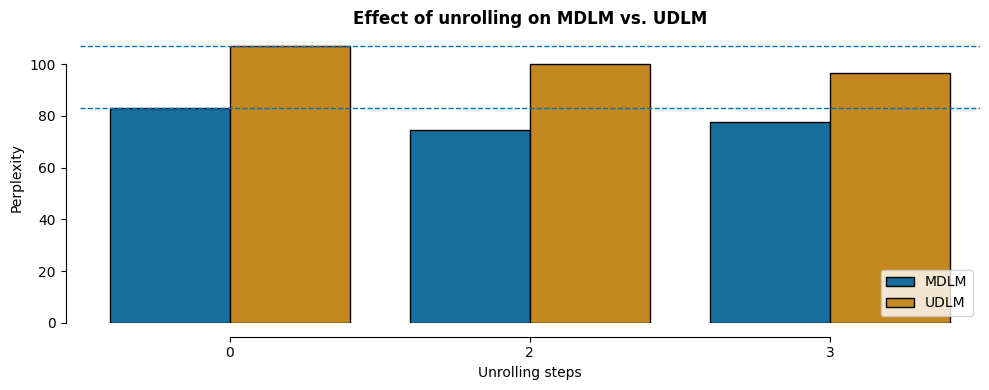

In [6]:
df = pd.DataFrame({
    "Unrolling Steps": ["0", "2", "3"] * 2,
    "Perplexity":      [83.0, 74.7, 77.5, 106.9, 99.9, 96.7],
    "Model":           ["MDLM"] * 3 + ["UDLM"] * 3
})

# 2) Minimal‑style bar plot
# sns.set_theme(style="whitegrid", font_scale=1.1)
# palette = sns.color_palette("muted")

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=df,
    x="Unrolling Steps",
    y="Perplexity",
    hue="Model",
    # palette=palette,
    edgecolor="black",
    ax=ax
)

# 3) Dotted baselines for each architecture
ax.axhline(83.0,  ls="--", lw=1, label="MDLM baseline")
ax.axhline(106.9, ls="--", lw=1, label="UDLM baseline")

# 4) Finishing touches
ax.set_xlabel("Unrolling steps")
ax.set_ylabel("Perplexity")
ax.set_title("Effect of unrolling on MDLM vs. UDLM")
sns.despine(offset=10, trim=True)

# Ensure both bar legend and baseline legend show
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], frameon=True, loc="lower right")
# ax.set_ylim(50, 120)

plt.tight_layout()
plt.savefig("unrolling.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
def plot_random_length_perplexity(data, model_name):
    df   = pd.DataFrame(data).set_index("var_pct")
    ppl  = df[["L8", "L16", "L32", "L64", "L128"]]

    diff_pct = pd.DataFrame(index=ppl.index, columns=ppl.columns, dtype=float)

    for col in ppl.columns:
        base = ppl.loc["0%", col]
        diff_pct[col] = (ppl[col] - base) / base

    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(5, 3))

    pastel_cmap = sns.diverging_palette(145, 10, s=60, l=85, as_cmap=True)  # pastel green↔white↔pastel red

    sns.heatmap(
        diff_pct,
        cmap=pastel_cmap,
        center=0,                   # white at baseline
        annot=ppl.round(1),         # show raw perplexities
        fmt=".1f",
        linewidths=.5,
        cbar=False,
        ax=ax
    )

    ax.set_xlabel("val sequence length")
    ax.set_ylabel("Variable-length batches")
    ax.set_xticklabels([c.replace('L', '') + ' tok' for c in ppl.columns])
    ax.set_title(f"{model_name} perplexity")

    plt.tight_layout()
    plt.savefig(f"var_length_{model_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

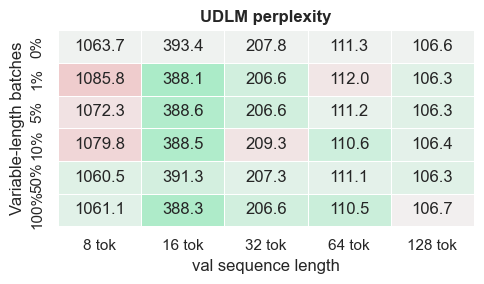

In [33]:
udlm_data = {
    "var_pct": ["0%", "1%", "5%", "10%", "50%", "100%"],
    "time_h":  [5.62, 5.58, 5.07, 5.52, 4.85, 4.18],
    "L8":      [1063.7, 1085.8, 1072.3, 1079.8, 1060.5, 1061.1],
    "L16":     [393.4,  388.1,  388.6,  388.5, 391.3,  388.3],
    "L32":     [207.8,  206.6,  206.6,  209.3, 207.3,  206.6],
    "L64":     [111.3,  112.0,  111.2,  110.6, 111.1,  110.5],
    "L128":    [106.6,  106.3,  106.3,  106.4, 106.3,  106.7],
}
plot_random_length_perplexity(udlm_data, 'UDLM')


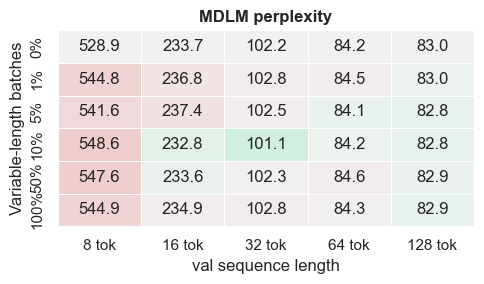

In [34]:
mdlm_data = {
    "var_pct": ["0%", "1%", "5%", "10%", "50%", "100%"],
    "time_h":  [3.75, 3.70, 3.45, 3.40, 3.18, 2.68],   # hours as decimals
    "L8":      [528.948, 544.758, 541.572, 548.637, 547.562, 544.875],
    "L16":     [233.743, 236.804, 237.367, 232.768, 233.569, 234.904],
    "L32":     [102.152, 102.772, 102.541, 101.107, 102.308, 102.769],
    "L64":     [84.202, 84.549, 84.062, 84.180, 84.636, 84.324],
    "L128":    [83.007, 82.976, 82.829, 82.774, 82.948, 82.853],
}

plot_random_length_perplexity(mdlm_data, 'MDLM')

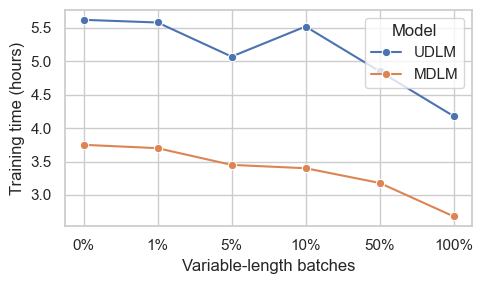

In [43]:
def plot_time_vs_varpct(udlm_dict: dict, mdlm_dict: dict):
    """
    Plot training time (hours) versus percentage of variable‑length batches
    for UDLM and MDLM on one uniform‑spaced categorical x‑axis.

    Parameters
    ----------
    udlm_dict : dict
        Dictionary with keys 'var_pct' and 'time_h' (plus any extras) for UDLM.
    mdlm_dict : dict
        Same structure for MDLM.
    """
    # ------------------------------------------------------------------
    # 1. Build tidy DataFrame
    # ------------------------------------------------------------------
    udlm_df = pd.DataFrame({
        "var_pct": udlm_dict["var_pct"],
        "time_h":  udlm_dict["time_h"],
        "model":   "UDLM",
    })
    mdlm_df = pd.DataFrame({
        "var_pct": mdlm_dict["var_pct"],
        "time_h":  mdlm_dict["time_h"],
        "model":   "MDLM",
    })
    df = pd.concat([udlm_df, mdlm_df], ignore_index=True)

    # ordered categorical so ticks are evenly spaced in string order
    df["var_pct"] = pd.Categorical(
        df["var_pct"],
        categories=udlm_dict["var_pct"],  # ["0%", "1%", "5%", ...] in order
        ordered=True,
    )

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(5, 3))

    sns.lineplot(
        data=df,
        x="var_pct",
        y="time_h",
        hue="model",
        marker="o",
        ax=ax,
    )

    ax.set_xlabel("Variable-length batches")
    ax.set_ylabel("Training time (hours)")
    # ax.set_title("Training time vs. variable-length share")
    ax.legend(title="Model", loc="upper right", frameon=True)

    plt.tight_layout()
    plt.savefig("time_var_length.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_time_vs_varpct(udlm_data, mdlm_data)


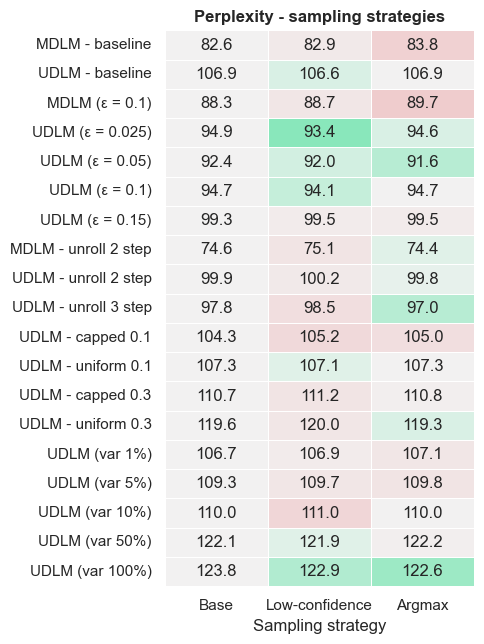

In [47]:
rows = [
    # (row‑name, base, low‑conf, argmax)
    ("MDLM - baseline",                 82.6,  82.9,  83.8),
    ("UDLM - baseline",                106.9, 106.6, 106.9),

    ("MDLM (ε = 0.1)",                  88.3,  88.7,  89.7),
    ("UDLM (ε = 0.025)",                94.9,  93.4,  94.6),
    ("UDLM (ε = 0.05)",                 92.4,  92.0,  91.6),
    ("UDLM (ε = 0.1)",                  94.7,  94.1,  94.7),
    ("UDLM (ε = 0.15)",                 99.3,  99.5,  99.5),

    ("MDLM - unroll 2 step",            74.6,  75.1,  74.4),
    ("UDLM - unroll 2 step",            99.9, 100.2,  99.8),
    ("UDLM - unroll 3 step",            97.8,  98.5,  97.0),

    ("UDLM - capped 0.1",              104.3, 105.2, 105.0),
    ("UDLM - uniform 0.1",             107.3, 107.1, 107.3),
    ("UDLM - capped 0.3",              110.7, 111.2, 110.8),
    ("UDLM - uniform 0.3",             119.6, 120.0, 119.3),

    ("UDLM (var 1%)",                 106.7, 106.9, 107.1),
    ("UDLM (var 5%)",                 109.3, 109.7, 109.8),
    ("UDLM (var 10%)",                110.0, 111.0, 110.0),
    ("UDLM (var 50%)",                122.1, 121.9, 122.2),
    ("UDLM (var 100%)",               123.8, 122.9, 122.6),
]

df = pd.DataFrame(rows,
                  columns=["config", "Base", "Low-confidence", "Argmax"]
).set_index("config")

# ------------------------------------------------------------------
# 2. Build colour values: diff = Base − {Low‑confidence, Argmax}
#    (Base column stays all‑white; colours depend on global extrema)
# ------------------------------------------------------------------
diff = df.copy()
for col in ["Low-confidence", "Argmax"]:
    diff[col] = df[col] - df["Base"]      # +ve ⇒ improvement, −ve ⇒ worse
diff["Base"] = 0                          # baseline = zero difference

pos_max = diff.clip(lower=0).max().max()             # best overall improvement
neg_max = (-diff.clip(upper=0)).max().max()          # worst overall degradation

norm = diff.copy()
norm[diff > 0]  = diff[diff > 0]  / pos_max if pos_max else 0
norm[diff < 0]  = diff[diff < 0]  / neg_max if neg_max else 0
# norm now in [-1 … 1] globally

# ------------------------------------------------------------------
# 3. Plot heat‑map with pastel diverging palette, no colour‑bar
# ------------------------------------------------------------------
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(5, 6.6))

sns.heatmap(
    norm,
    cmap=sns.diverging_palette(150, 10, s=60, l=85, as_cmap=True),  # pastel red↔white↔green
    center=0,
    annot=df.round(1),
    fmt=".1f",
    linewidths=.5,
    cbar=False,
    ax=ax
)

ax.set_xlabel("Sampling strategy")
ax.set_ylabel("")
ax.set_title("Perplexity - sampling strategies")

plt.tight_layout()
plt.savefig("sampling_strategies.png", dpi=300, bbox_inches="tight")
plt.show()

In [52]:
bars.containers[0]

<BarContainer object of 1 artists>

22.32
27.04
31.28
32.79
40.25


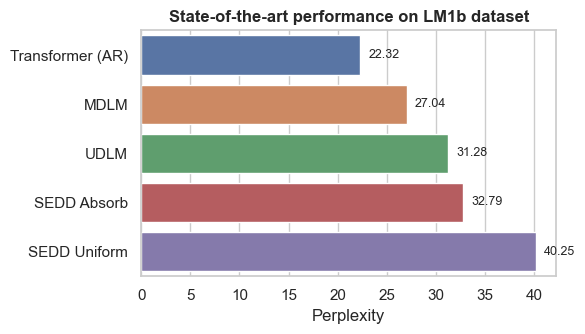

In [65]:
models = [
    "Transformer (AR)",
    "SEDD Absorb",
    "MDLM",
    "SEDD Uniform",
    "UDLM"
]
ppl = [22.32, 32.79, 27.04, 40.25, 31.28]

df = pd.DataFrame({"Model": models, "PPL": ppl})

sns.set_theme(style="whitegrid")
palette = sns.color_palette("pastel", len(df))

fig, ax = plt.subplots(figsize=(6, 3.5))
bars = sns.barplot(
    data=df.sort_values("PPL"),       # order by perplexity (lower is better)
    x="PPL",
    y="Model",
    # palette=palette,
    hue="Model",
    ax=ax
)

# annotate bars with exact values
for bar in bars.containers:
    bar = bar[0]
    width = bar.get_width()
    print(width)
    ax.text(
        width + 0.8,                  # horizontal offset
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va="center",
        ha="left",
        fontsize=9
    )

ax.set_title("State-of-the-art performance on LM1b dataset")
ax.set_xlabel("Perplexity")
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("state_of_the_art_performance.png", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
27.04 / 22.32 - 1, 31.28 / 22.32 - 1

(0.2114695340501791, 0.4014336917562724)